<a href="https://colab.research.google.com/github/Min1222Ag/AISecApp/blob/main/mosaic_skeleton_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# CIFAR-10 데이터셋 로드
(x_train, _), (x_test, _) = cifar10.load_data()

# 데이터 정규화
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 모자이크 이미지 생성 함수
def create_mosaic(images, size=4):
    mosaic_images = np.copy(images)
    for img in mosaic_images:
        for i in range(0, img.shape[0], size):
            for j in range(0, img.shape[1], size):
                mosaic_images[i:i+size, j:j+size] = np.mean(img[i:i+size, j:j+size, :], axis=(0, 1))
    return mosaic_images

# 모자이크 이미지 생성
x_train_mosaic = create_mosaic(x_train)
x_test_mosaic = create_mosaic(x_test)

170498071/170498071 [==============================] - 3s 0us/step


In [2]:
# Encoder
input_img = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [6]:
autoencoder.fit(x_train_mosaic, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_mosaic, x_test))


Epoch 1/5
391/391 [==============================] - 294s 752ms/step - loss: 0.5597 - val_loss: 0.5600
Epoch 2/5
391/391 [==============================] - 292s 746ms/step - loss: 0.5587 - val_loss: 0.5594
Epoch 3/5
391/391 [==============================] - 285s 729ms/step - loss: 0.5579 - val_loss: 0.5589
Epoch 4/5
391/391 [==============================] - 281s 720ms/step - loss: 0.5575 - val_loss: 0.5582
Epoch 5/5
391/391 [==============================] - 279s 714ms/step - loss: 0.5569 - val_loss: 0.5605


In [7]:
# Encoder 부분만 추출
encoder = Model(input_img, encoded)

# 새로운 모자이크 처리 모델 정의
encoded_input = Input(shape=(8, 8, 32))  # Encoder의 출력 형태와 동일해야 함
decoder_layer = autoencoder.layers[-5](encoded_input)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_output = autoencoder.layers[-1](decoder_layer)

mosaic_model = Model(encoded_input, decoder_output)


313/313 [==============================] - 7s 22ms/step


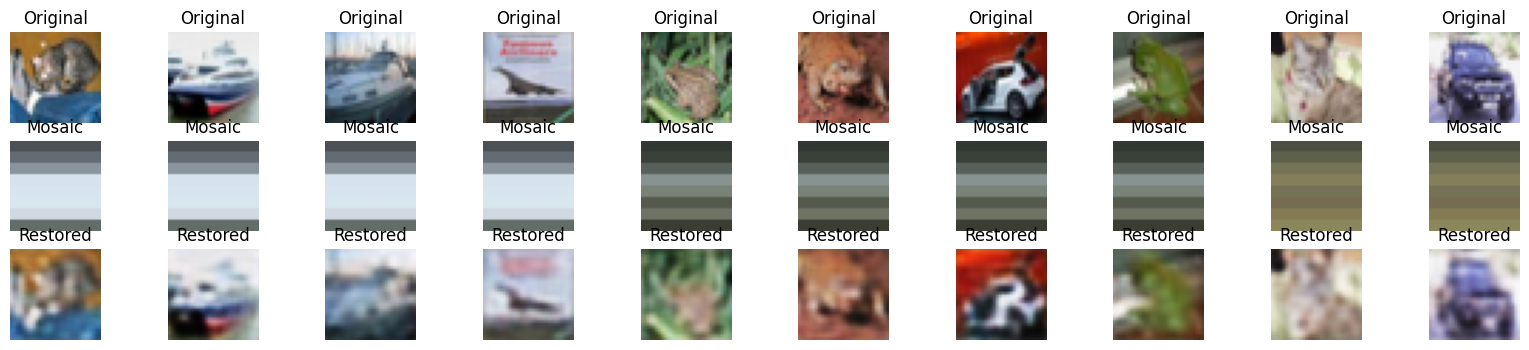

In [8]:
# 원본 이미지를 모자이크 처리
encoded_imgs = encoder.predict(x_test)
mosaic_imgs = mosaic_model.predict(encoded_imgs)

# 결과 확인
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # 모자이크 이미지
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_mosaic[i])
    plt.title("Mosaic")
    plt.axis("off")

    # 복원된 이미지
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(mosaic_imgs[i])
    plt.title("Restored")
    plt.axis("off")
plt.show()
